# 1.データの取り込み

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
pd.set_option('display.max_columns',150)

In [2]:
# 来月の商品の売上個数を予測しよう！商品の日付ごとの売上個数などのデータを利用
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
display(train.head())
display(test.head())


,date,date_block_num,item_id,item_category_id,item_cnt_day
0,02.01.2013,0,22154,37,1.0
1,22.01.2013,0,4907,23,1.0
2,11.01.2013,0,4907,23,1.0
3,08.01.2013,0,2258,28,1.0
4,23.01.2013,0,2258,28,1.0


,item_id,date_block_num
0,0,33
1,1,33
2,2,33
3,3,33
4,4,33


# 2.データ探索(eda)とデータ集計処理

In [3]:
print("==========\ntrain\n===========")

display(train.info())
display(train.describe())
display(train.describe(include="object"))
display(train.isnull().sum())
display(train.shape)

print("==========\ntest\n===========")
display(test.info())
display(test.describe())
# display(test.describe(include="object"))
display(test.isnull().sum())
display(test.shape)

train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2882335 entries, 0 to 2882334
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   date_block_num    int64  
 2   item_id           int64  
 3   item_category_id  int64  
 4   item_cnt_day      float64
dtypes: float64(1), int64(3), object(1)
memory usage: 110.0+ MB


None

,date_block_num,item_id,item_category_id,item_cnt_day
count,2.882335e+06,2.882335e+06,2.882335e+06,2.882335e+06
mean,1.422773e+01,1.018604e+04,3.995896e+01,1.241060e+00
std,9.166123e+00,6.326743e+03,1.707675e+01,2.283184e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+01
25%,6.000000e+00,4.466000e+03,2.800000e+01,1.000000e+00
50%,1.300000e+01,9.250000e+03,4.000000e+01,1.000000e+00
75%,2.200000e+01,1.569300e+04,5.500000e+01,1.000000e+00
max,3.200000e+01,2.216900e+04,8.300000e+01,1.000000e+03


,date
count,2882335
unique,1003
top,28.12.2013
freq,9434


date                0
date_block_num      0
item_id             0
item_category_id    0
item_cnt_day        0
dtype: int64

(2882335, 5)

test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21332 entries, 0 to 21331
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   item_id         21332 non-null  int64
 1   date_block_num  21332 non-null  int64
dtypes: int64(2)
memory usage: 333.4 KB


None

,item_id,date_block_num
count,21332.000000,21332.0
mean,11072.501453,33.0
std,6371.206639,0.0
min,0.000000,33.0
25%,5539.750000,33.0
50%,11061.500000,33.0
75%,16603.250000,33.0
max,22169.000000,33.0


item_id           0
date_block_num    0
dtype: int64

(21332, 2)

In [4]:
# item_cnt_dayがマイナスのもの
display(train[train["item_cnt_day"] < 0])

# 返品数が多い商品 + 月の把握
train[train["item_cnt_day"] < 0].groupby(["item_id","date_block_num"],as_index=False).sum().sort_values("item_cnt_day").head(10)[["item_id","date_block_num","item_cnt_day"]]


,date,date_block_num,item_id,item_category_id,item_cnt_day
312,07.01.2013,0,19679,41,-1.0
633,10.01.2013,0,2252,30,-1.0
676,13.01.2013,0,21395,37,-1.0
957,28.01.2013,0,2308,30,-1.0
2063,05.01.2013,0,1836,19,-1.0
...,...,...,...,...,...
2880714,07.09.2015,32,14400,37,-1.0
2881391,28.09.2015,32,2780,20,-1.0
2881491,19.09.2015,32,1847,19,-1.0
2881548,23.09.2015,32,5902,20,-1.0


,item_id,date_block_num,item_cnt_day
694,2331,13,-24.0
3379,8023,10,-22.0
692,2331,11,-19.0
5997,20949,18,-17.0
1431,3732,9,-14.0
357,1590,0,-13.0
3578,9242,21,-10.0
1453,3734,10,-10.0
2134,5228,2,-9.0
2133,5228,1,-8.0


In [5]:
# item毎にitem_categoryが1つであることを確認
train.groupby("item_id").nunique("item_category_id").sort_values("item_category_id",ascending=False)["item_category_id"]

item_id
0        1
14769    1
14767    1
14764    1
14763    1
        ..
7395     1
7394     1
7393     1
7392     1
22169    1
Name: item_category_id, Length: 21332, dtype: int64

In [6]:
#item_id毎に月次の個数を集計(date_block_numがあるため、dateは今回は使用しない)
df_train = train.drop("date",axis=1).groupby(["item_id","date_block_num","item_category_id"],as_index=False).sum()
df_train.head()

,item_id,date_block_num,item_category_id,item_cnt_day
0,0,20,40,1.0
1,1,15,76,2.0
2,1,18,76,1.0
3,1,19,76,1.0
4,1,20,76,1.0


<Axes: xlabel='date_block_num', ylabel='item_cnt_day'>

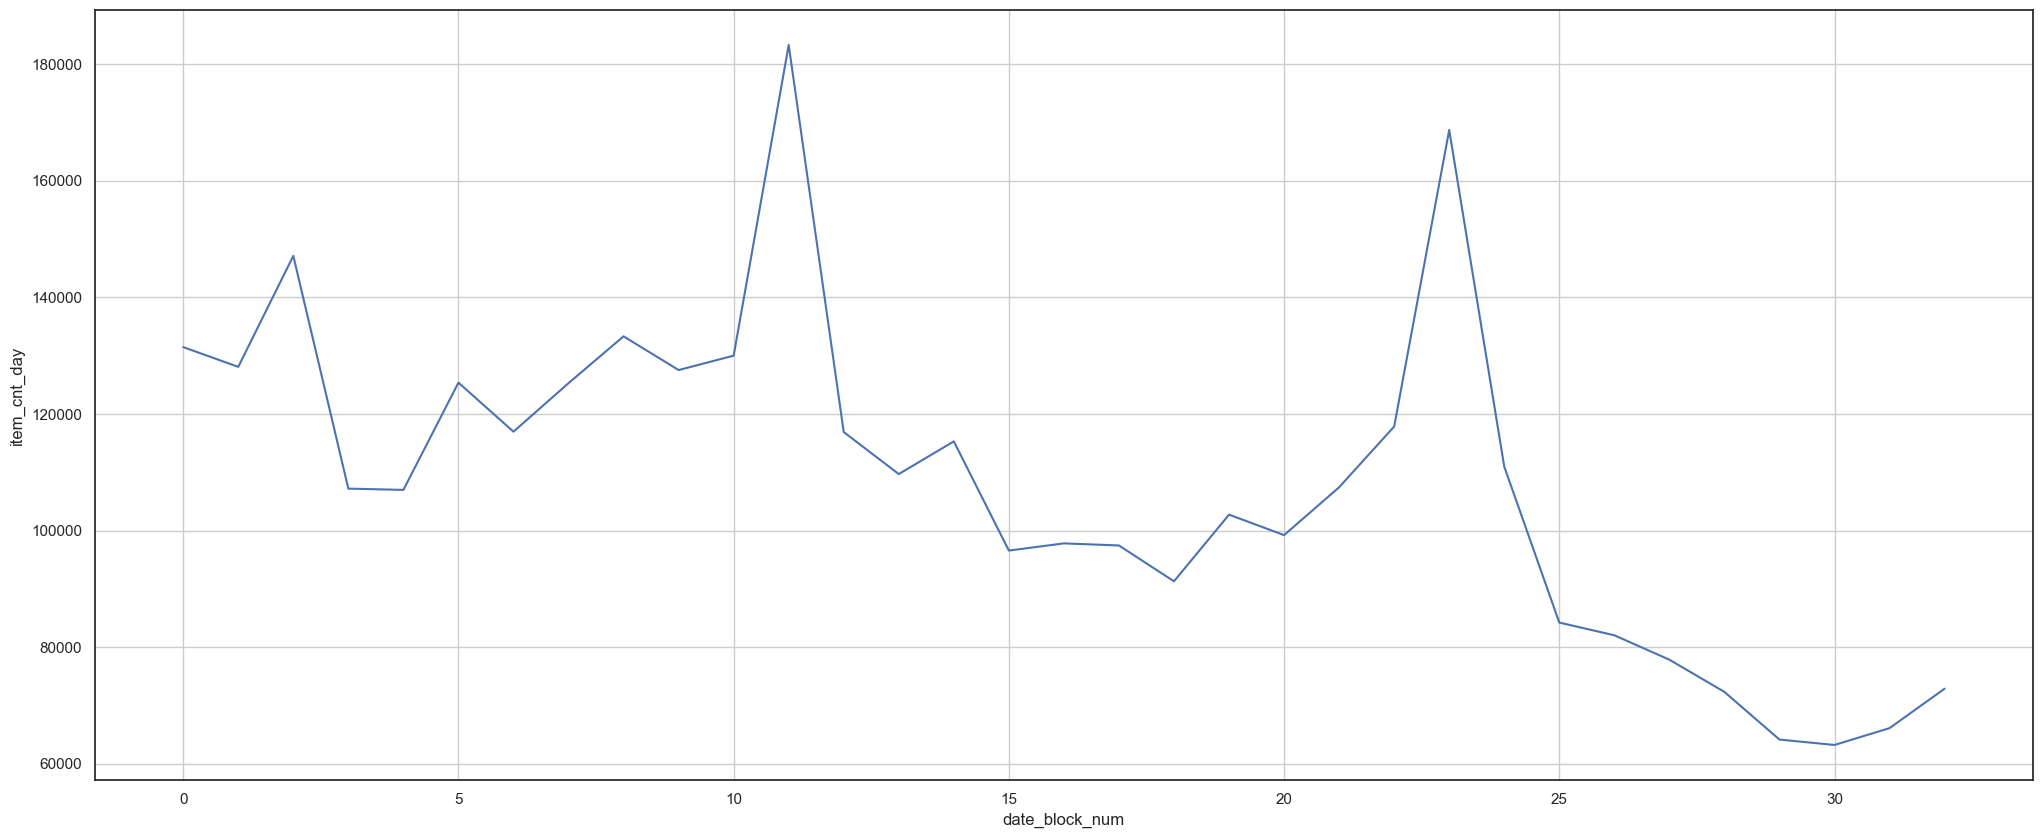

In [7]:
#全体の販売個数推移
plt.figure(figsize=(25,10))
plt.grid(True)
graph_df = df_train.groupby("date_block_num",as_index=False).sum()
sns.lineplot(data=graph_df,x="date_block_num",y="item_cnt_day")

#全体的に販売個数は減少傾向
##1年毎に周期性あり、date_block_numが11と23の月(12月)は販売個数が上がる傾向があるため注意が必要
#今回予測するのは10月は1年前よりも1ヶ月前のデータの方が相関強そう

<Axes: xlabel='date_block_num', ylabel='item_cnt_day'>

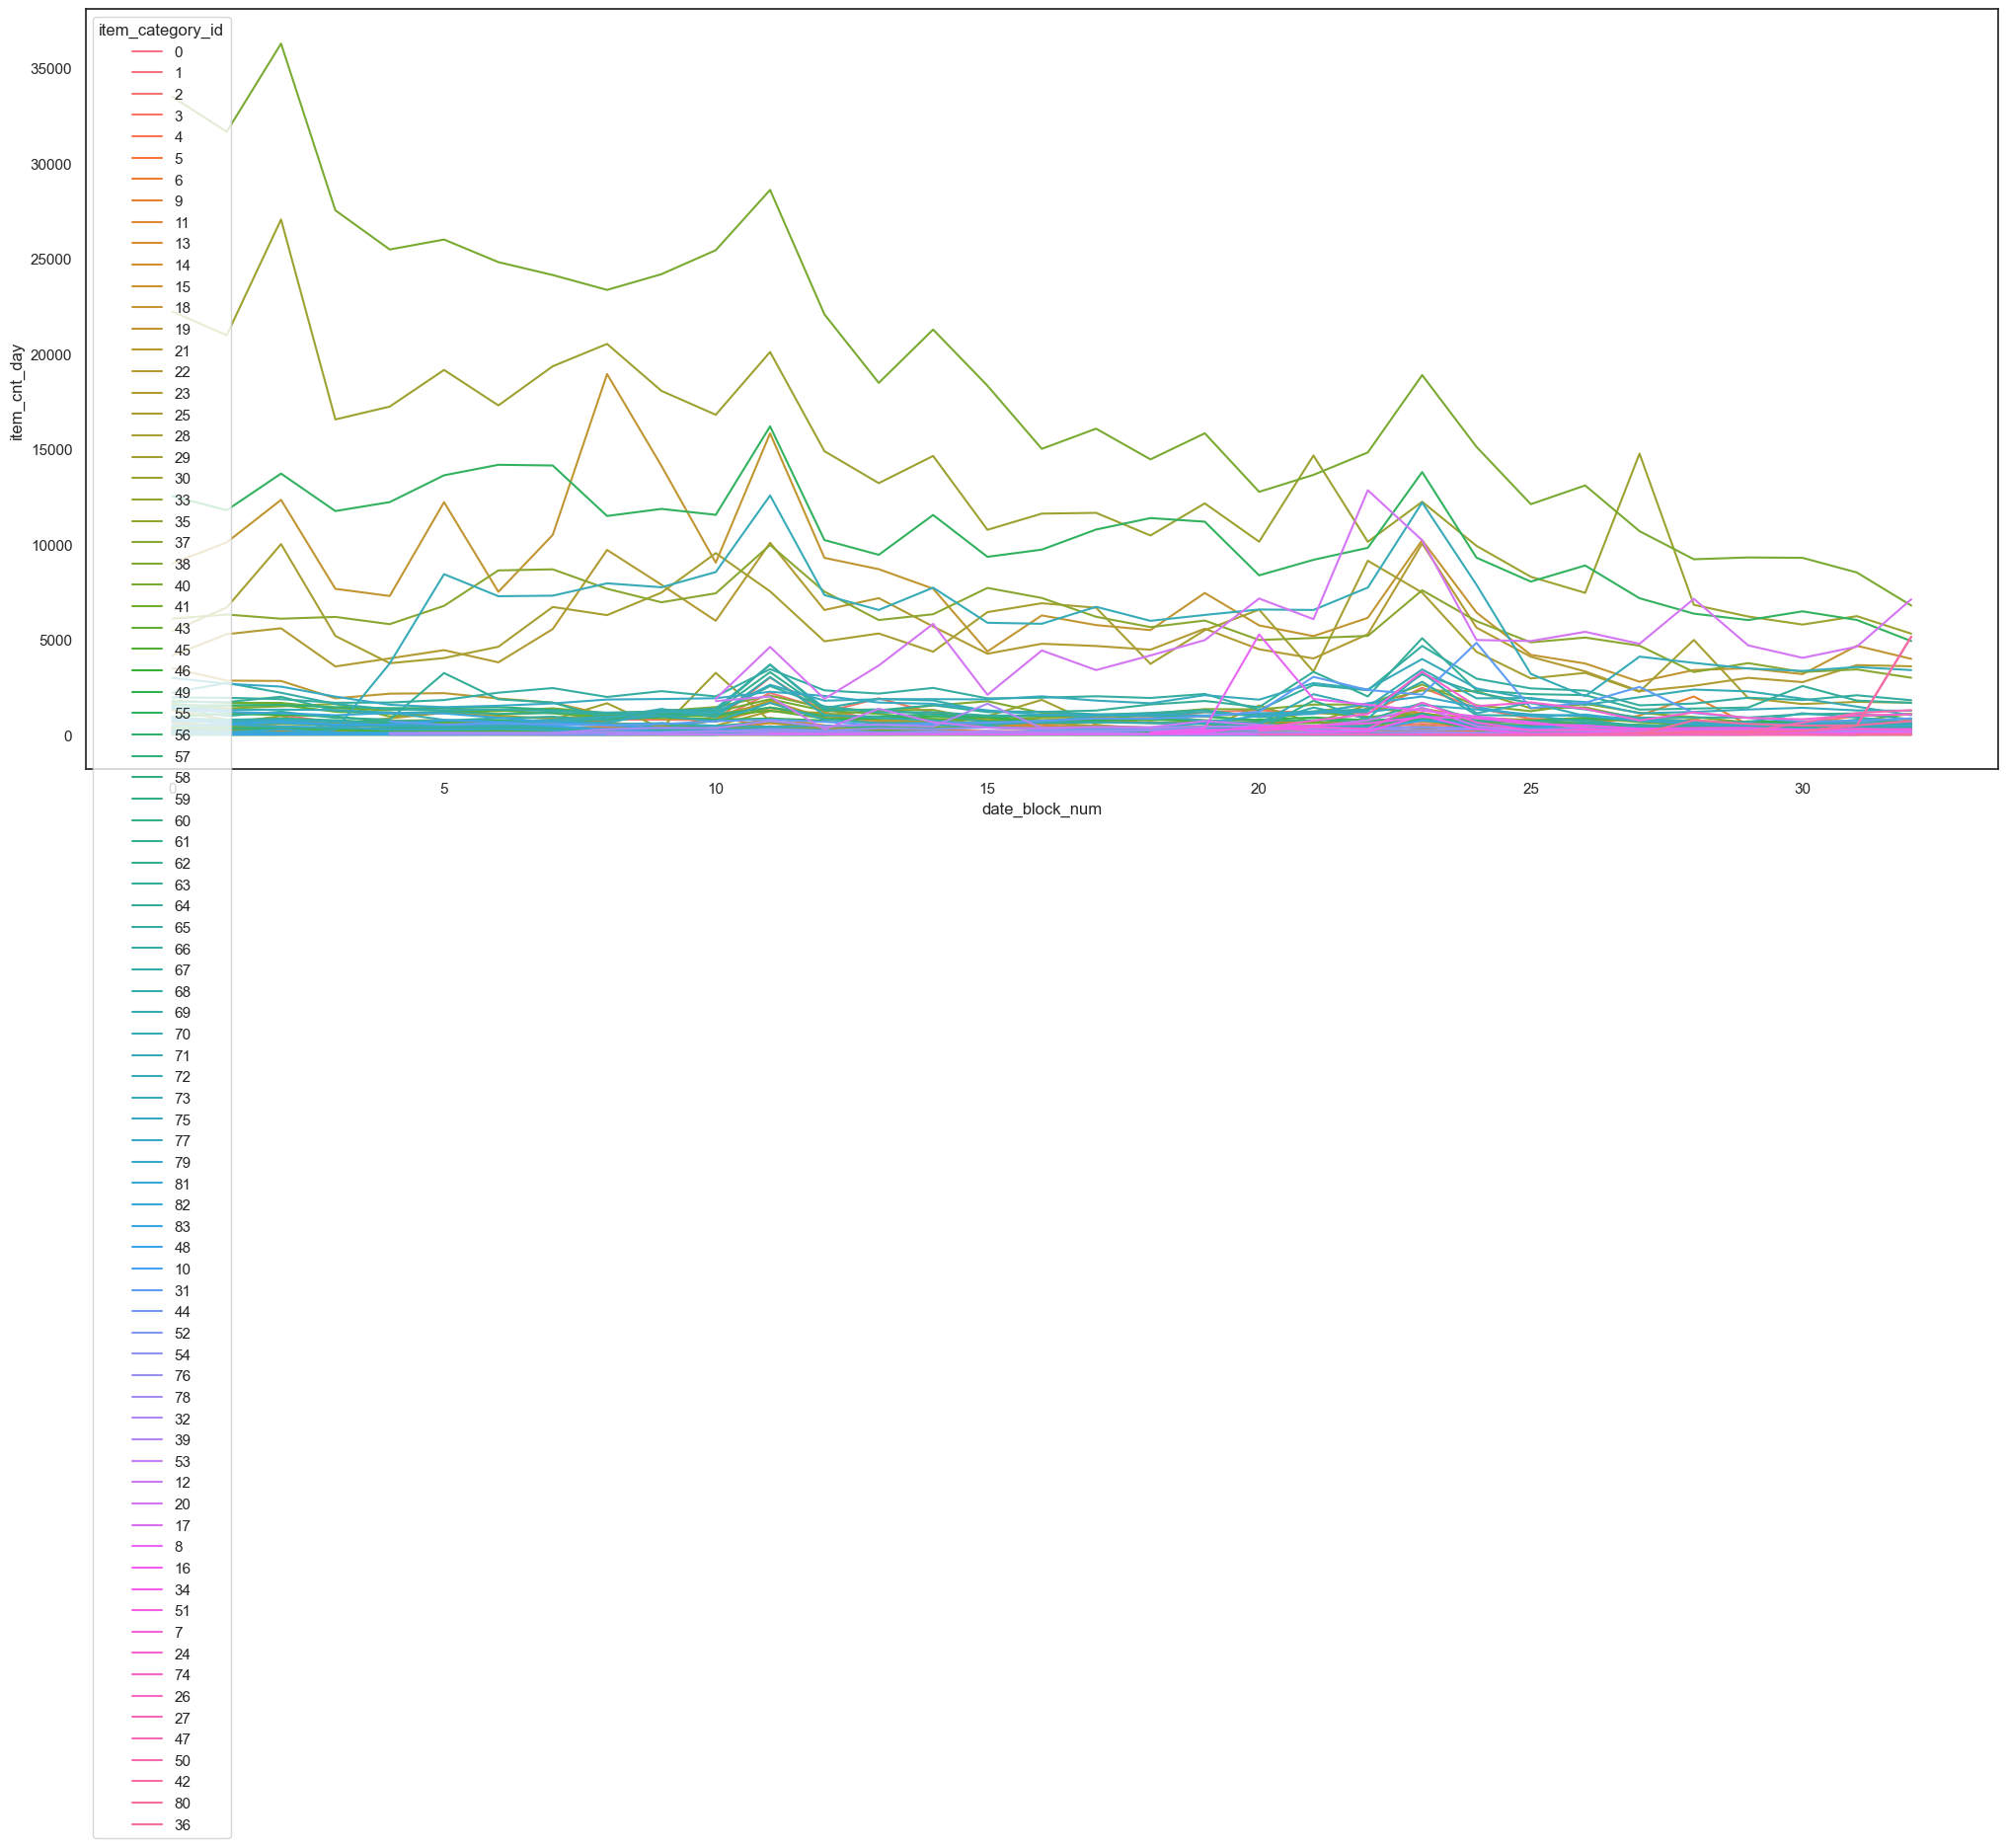

In [8]:
#item_categoryごとの販売個数推移
plt.figure(figsize=(25,10))
df_graph = df_train.groupby(["date_block_num","item_category_id"],as_index=False).sum()
df_graph["item_category_id"] = df_graph["item_category_id"].astype("str")
sns.lineplot(data=df_graph, x="date_block_num",y="item_cnt_day",hue="item_category_id")

#どのカテゴリーも似たような動きをしている

In [11]:
#まずはアイテムごとの月次販売個数のみを使用して予測してみる
df_train_naive=df_train.groupby(["date_block_num","item_id"],as_index=False).sum()
df_train_naive

,date_block_num,item_id,item_category_id,item_cnt_day
0,0,19,40,1.0
1,0,27,19,7.0
2,0,28,30,8.0
3,0,29,23,4.0
4,0,32,40,299.0
...,...,...,...,...
228494,32,22162,40,7.0
228495,32,22163,40,20.0
228496,32,22164,37,9.0
228497,32,22166,54,5.0


In [12]:
df_train_naive = pd.pivot_table(df_train_naive,index="item_id",columns="date_block_num",values="item_cnt_day")
df_train_naive

date_block_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,24.0,32.0,25.0,24.0,21.0,13.0,10.0,15.0,12.0,13.0,13.0,12.0,16.0,11.0,7.0,8.0,12.0,4.0,8.0,10.0,8.0,11.0,5.0
22167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,146.0,96.0,83.0,66.0,57.0,47.0,59.0,41.0,56.0,47.0,47.0,39.0,49.0,49.0,40.0,33.0,46.0,40.0,38.0,31.0,33.0,34.0,29.0,21.0


# 3.機械学習の前処理

In [9]:


#pivotに変換し、空欄は0を挿入(機械学習にかけるため、縦持ちデータを横持ちデータに変換)
df_train_naive = df_train_naive.fillna(0)
df_train_naive = df_train_naive.reset_index()
df_train_naive

NameError: name 'df_train_native' is not defined

In [ ]:
#学習用と検証用の特徴量作成
# テストデータは予測する月の前年周期(date_block_num=21)、学習データはテストデータ以前のもののみ使用
# 特徴量は先月の販売個数(短期の自己相関)、前年周月の販売個数(周期変動)、先月の前年同月比(長期トレンド要素)、先々月と先月の比(短期トレンド要素) ※外因性要素は今回なし

X_train = X_train.copy()

X_train = df_train_naive[["item_id",19,8,7,18]]
X_train.columns = ["item_id","1M","1Y","1Y+1M","2M"]
X_train["long_trend"] = (X_train["1M"]+0.00001) / (X_train["1Y+1M"] + 0.00001)# 少ない数を足して分母が0にならないように調整
X_train["short_trend"] = (X_train["1M"]  +0.00001) / (X_train["2M"] + 0.00001)
X_train = X_train.drop(["item_id","1Y+1M","2M"],axis=1)
y_train = df_train_naive[20]

X_test = X_test.copy()

X_test = df_train_naive[["item_id",19,8,7,18]]
X_test.columns = ["item_id","1M","1Y","1Y+1M","2M"]
X_test["long_trend"] = (X_test["1M"]+0.00001) / (X_test["1Y+1M"] + 0.00001)# 少ない数を足して分母が0にならないように調整
X_test["short_trend"] = (X_test["1M"]  +0.00001) / (X_test["2M"] + 0.00001)
X_test = X_test.drop(["item_id","1Y+1M","2M"],axis=1)
X_test = df_train_naive[21]

display(X_train.info())
display(X_test.info())
display(X_train.head())
display(X_test.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21332 entries, 0 to 21331
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   1M           21332 non-null  float64
 1   1Y           21332 non-null  float64
 2   long_trend   21332 non-null  float64
 3   short_trend  21332 non-null  float64
dtypes: float64(4)
memory usage: 666.8 KB


/var/folders/gv/jdl3jb_n5_n7dmjltlz8wbm40000gn/T/ipykernel_74397/2858861381.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["long_trend"] = (X_train["1M"]+0.00001) / (X_train["1Y+1M"] + 0.00001)# 少ない数を足して分母が0にならないように調整
/var/folders/gv/jdl3jb_n5_n7dmjltlz8wbm40000gn/T/ipykernel_74397/2858861381.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["short_trend"] = (X_train["1M"]  +0.00001) / (X_train["2M"] + 0.00001)
/var/folders/gv/jdl3jb_n5_n7dmjltlz8wbm40000gn/T/ipykernel_74397/28588613

None

<class 'pandas.core.series.Series'>
RangeIndex: 21332 entries, 0 to 21331
Series name: 21
Non-Null Count  Dtype  
--------------  -----  
21332 non-null  float64
dtypes: float64(1)
memory usage: 166.8 KB


None

,1M,1Y,long_trend,short_trend
0,0.0,0.0,1.0,1.0
1,1.0,0.0,100001.0,1.0
2,1.0,0.0,100001.0,100001.0
3,1.0,0.0,100001.0,1.0
4,0.0,0.0,1.0,1.0


0    0.0
1    1.0
2    0.0
3    0.0
4    0.0
Name: 21, dtype: float64

# 4.予測と評価

In [ ]:
#重回帰分析(sklearn)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

# スコア算出
from sklearn.metrics import r2_score,mean_squared_error
print("r2=",r2_score(y_true=y_test,y_pred=y_pred))
print("RMSE=",np.sqrt(mean_squared_error(y_true=y_test,y_pred=y_pred)))
#回帰係数算出
pd.DataFrame(lr.coef_, index=X_train.columns)

/Users/sekiguchiyuma/Library/CloudStorage/GoogleDrive-yuuuuuma1101@gmail.com/マイドライブ/タスク/IT/pythonファイナンス分析(キノクエスト)/1.株価のデータを可視化してみよう01/1.dataset/kadai/kino_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [ ]:
#決定木分析
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=30,random_state=1)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

#スコア算出
from sklearn.metrics import r2_score, mean_squared_error
print("r2=",r2_score(y_true=y_test,y_pred=y_pred))
print("RMSE=",np.sqrt(mean_squared_error(y_true=y_test,y_pred=y_pred)))

#　重回帰分析を採用

/Users/sekiguchiyuma/Library/CloudStorage/GoogleDrive-yuuuuuma1101@gmail.com/マイドライブ/タスク/IT/pythonファイナンス分析(キノクエスト)/1.株価のデータを可視化してみよう01/1.dataset/kadai/kino_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [ ]:
# ベースラインモデル
y_pred = X_test["1M"]
print("r2=",r2_score(y_true=y_test,y_pred=y_pred))
print("RMSE=",np.sqrt(mean_squared_error(y_true=y_test,y_pred=y_pred)))


KeyError: '1M'

In [ ]:
#予測用データ作成+予測
X_test = df_train_naive[["item_id",32,21,20,31]]
X_test.columns=["item_id","1M","1Y","1Y+1M","2M"]
X_test["long_trend"]=(X_test["1M"]+0.00001)/(X_test["1Y+1M"]+0.00001)
X_test["short_trend"]=(X_test["1M"]+0.00001)/(X_test["2M"]+0.00001)
X_test=X_test.drop(["item_id","1Y+1M","2M"],axis=1)
y_pred = lr.predict(X_test)
pred_df = pd.DataFrame(df_train_naive["item_id"])
pred_df["y"] = y_pred

#サブミットデータ作成
X_test = pd.merge(test, pred_df, on="item_id", how="left")
X_test = X_test[["item_id", "y"]]
X_test.to_csv("sales_predict_submit.csv", index=False)
X_test
#最終スコアはRMSE=20.62

/var/folders/gv/jdl3jb_n5_n7dmjltlz8wbm40000gn/T/ipykernel_74397/1988887080.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["long_trend"]=(X_test["1M"]+0.00001)/(X_test["1Y+1M"]+0.00001)
/var/folders/gv/jdl3jb_n5_n7dmjltlz8wbm40000gn/T/ipykernel_74397/1988887080.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["short_trend"]=(X_test["1M"]+0.00001)/(X_test["2M"]+0.00001)


,item_id,y
0,0,1.052123
1,1,1.064504
2,2,1.052119
3,3,1.052119
4,4,1.052123
...,...,...
21327,22165,1.052119
21328,22166,6.175911
21329,22167,22.554700
21330,22168,1.052119


# 5.おまけ(item_categoryidをtarget encodingして特徴量に追加する)